In [1]:
#
# For each independent variable, we need to generate equivalents between the ACS and the FMLI
#

import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

dependents = ['TOTEXP','FOOD','ALCBEV','HOUS','APPAR','TRANS','HEALTH', 'ENTERT',
           'PERSCA', 'READ','EDUCA','TOBACC','MISC', 'CASHCO','RETPEN']

independents = ['income_z',
                'incbin',
                'homeownership',
                'vehicles_0_1',
                'married',
                'children',
                'bedroomstwofewer',                
               ]

#
# Load the source datasets
#

fmli = pd.read_pickle('fmli.pkl')
acs = pd.read_pickle('acs.pkl')
myvars = pd.read_csv("myvars.csv")
cu = sum((fmli.FINLWT21 * fmli.MO_SCOPE / 3) / 4)

print("Dataframes loaded with fmli:",fmli.shape[0]," and acs:",acs.shape[0])


#
# Cleanup
#

# Cast data types
for f in ["CUTENURE","FINCBTXM","VEHQ","FAM_TYPE"]:
    fmli[f] = fmli[f].astype(int)

# Dependent variables are highly right skewed
# Logs look normal, EXCEPT most categories reasonably have 0 values
#for d in dependents:
#    print(d,sum(fmli[d] <= 0) / fmli.shape[0])
#    """fmli["log_"+d] = np.log(0.1+fmli[d])
#    fmli["log_"+d].hist(bins=40)
#    plt.show()"""

# Incomplete interviews
fmli = fmli[fmli.TOTEXP > 0].copy()     # 1627 rows removed, incomplete surveys
fmli = fmli[fmli.FINCBTXM > 0].copy()   # 70 rows removed

acs = acs[acs.B25003_001E > 0].copy()  # 2801 block groups have no households
acs = acs[acs.B01001_001E > 0].copy()  # 2164 block groups have no people
acs = acs[acs.B02001_001E > 0].copy()  # 2164 have no race basis variable

# NAs
print("Looking for NAs")
for c in ['TQ_'+d for d in dependents]:
    if fmli[c].isna().sum() > 0:
        print(c,fmli[c].isna().sum())
print("NAs found:",fmli[['TQ_'+d for d in dependents]].isna().sum().sum())

# Outliers
for d in dependents:
    fmli[d] = fmli[d+"PQ"]+fmli[d+"CQ"]

fmli = fmli[abs(fmli.TOTEXP) < (3 * fmli.TOTEXP.std())].copy()  # Loses 904 rows
    
#for depvar in dependents: # For each depvar, there are ~150 that are 5 std out, collective 6K
#    print(depvar,fmli[abs(fmli[depvar]) > 5 * fmli[depvar].std()].shape[0])

print("Dataframes cleaned with fmli:",fmli.shape[0]," and acs:",acs.shape[0])


Dataframes loaded with fmli: 23678  and acs: 242336
Looking for NAs
NAs found: 0
Dataframes cleaned with fmli: 22631  and acs: 239535


In [2]:
#
# Comparison utilities
#

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from tabulate import tabulate
import scipy.stats as st

def oe_hist(series):
    ax = series.hist(figsize=(12,10), bins=50)
    ax.set_xlabel("")
    ax.set_ylabel("Frequency")
    return ax

def oe_bar(series):
    series.plot(kind="bar")
    return ax

def oe_scatter(x,y):
    """
    Simple scatter chart comparing one variable against another
    """
    plt.scatter(x, y, color='red')
    plt.bins("", fontsize=14)
    plt.ylabel("", fontsize=14)
    plt.xlabel("", fontsize=14)
    plt.grid(True)
    return plt

def oe_corr(df):
    """
    Provides the correlation matrix as a heatmap
    """
    correlationmatrix = df.corr()
    fig = plt.figure(figsize = (15,15))
    return sb.heatmap(correlationmatrix, vmax = .8, square = True)

def compare(atitle,A,btitle,B,ctitle = None,C=None):
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize = (15,6))
    axs[0].hist(A.sample(min(A.shape[0],B.shape[0])), bins=20)
    axs[0].set_title(atitle)
    axs[1].hist(B.sample(min(A.shape[0],B.shape[0])), bins=20)
    axs[1].set_title(btitle)
    if C is not None:
        axs[2].hist(C, bins=20)
        axs[2].set_title(ctitle)
    print(tabulate([[atitle,A.mean(),A.std()], [btitle,B.mean(),B.std()]], headers=['Var','Mean', 'StdDev']))
    return

def get_best_distribution(data):
    # Available scipy.stats distributions:
    dist_names = [\
                  #'alpha','anglit','arcsine','argus','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','crystalball','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','gennorm','genpareto','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','genhyperbolic','geninvgauss',
                  #'gibrat',
                  'gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kappa4','kappa3',
                  #'ksone','kstwo','kstwobign',
                  'laplace','laplace_asymmetric','levy','levy_l',
                  #'levy_stable',
                  'logistic','loggamma','loglaplace','lognorm','loguniform','lomax','maxwell','mielke','moyal','nakagami','ncx2','ncf','nct','norm','norminvgauss','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','rayleigh','rice','recipinvgauss','semicircular','skewcauchy','skewnorm','studentized_range','t','trapezoid','triang','truncexpon','truncnorm',
                  #'truncweibull_min',
                  'tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max','wrapcauchy']
    # npdist = ['beta','binomial','chisquare','dirichlet','exponential','f','gamma','geometric','gumbel','hypergeometric','laplace','logistic','lognormal','logseries','multinomial','multivariate_normal','negative_binomial','noncentral_chisquare','noncentral_f','normal','pareto','poisson','power','rayleigh','standard_cauchy','standard_exponential','standard_gamma','standard_normal','standard_t','triangular','uniform','vonmises','wald','weibull','zipf']
    
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist],dist_results

In [4]:
#
#
# For each independent variable, related the weighted observation against ACS equivalent
#
#

Var                 Mean    StdDev
----------  ------------  --------
ACS Income  -2.76893e-15         1
CEX Income   4.68912e-16         1


incbin
E    0.224117
D    0.208696
F    0.179267
C    0.163758
B    0.130485
A    0.057222
G    0.036454
Name: proportion, dtype: float64

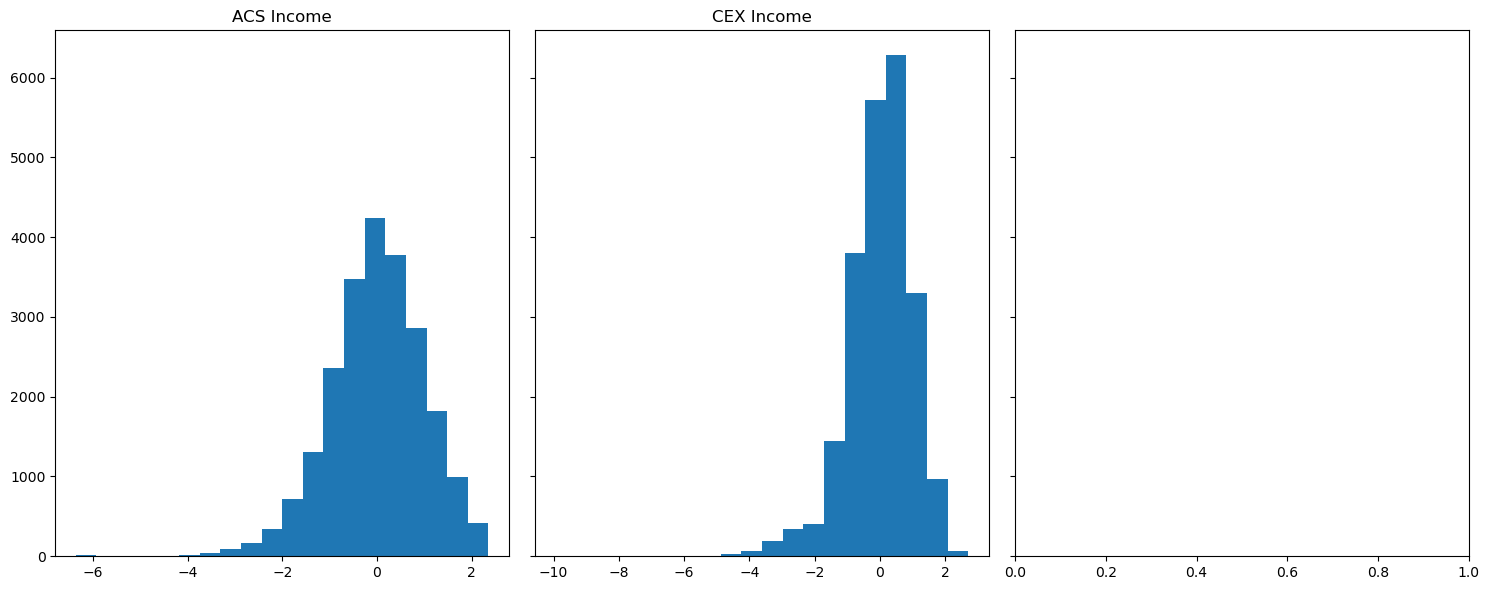

In [36]:
#
# Income before taxes
#
# ACS B19013e1   - median household income
#     B25003e1   - housing units
# B19025 Aggregate Household Income In The Past 12 Months (In 2019 Inflation-Adjusted Dollars)

# CEX FINCBTXM

acs = acs[acs.B19013_001E != -666666666]  # 14,405 rows use this as an NA placeholder
acs = acs[acs.B19013_001E != 250001]      # 2,431 rows use this topcoding

acs['income_log'] = np.log(acs.B19013_001E)
fmli['income_log'] = np.log(fmli.FINCBTXM)

acs['income_z'] = (acs.income_log-acs.income_log.mean())/acs.income_log.std()
fmli['income_z'] = (fmli.income_log-fmli.income_log.mean())/fmli.income_log.std()

compare("ACS Income",acs.income_z,"CEX Income", fmli.income_z)

fmli['incbin'] = np.where(fmli['income_z'] < -1.5, 'A',
                 np.where(fmli['income_z'] < -.75, 'B',
                 np.where(fmli['income_z'] < -.25, 'C',
                 np.where(fmli['income_z'] < .25, 'D',
                 np.where(fmli['income_z'] < .75, 'E', 
                 np.where(fmli['income_z'] < 1.5, 'F', 'G'))))))

fmli.incbin.value_counts(normalize=True)

In [27]:
fmli['incbin'] = np.where(fmli['income_z'] < -1.5, 'A',
                 np.where(fmli['income_z'] < -.75, 'B',
                 np.where(fmli['income_z'] < -.25, 'C',
                 np.where(fmli['income_z'] < .25, 'D',
                 np.where(fmli['income_z'] < .75, 'E', 
                 np.where(fmli['income_z'] < 1.5, 'F', 'G'))))))

In [20]:
breaks = [35000,75000,130000]
print("     low",sum(fmli.FINCBTXM < breaks[0])/fmli.shape[0])
print("lowermid",sum((fmli.FINCBTXM >= breaks[0])&(fmli.FINCBTXM < breaks[1]))/fmli.shape[0])
print("uppermid",sum((fmli.FINCBTXM >= breaks[1])&(fmli.FINCBTXM < breaks[2]))/fmli.shape[0])
print("    high",sum((fmli.FINCBTXM >= breaks[2]))/fmli.shape[0])


     low 0.2647253766956829
lowermid 0.27497680173213734
uppermid 0.22398479961115283
    high 0.2363130219610269


In [11]:
acs = acs[acs.B19013_001E != -666666666]  # 14,405 rows use this as an NA placeholder
acs = acs[acs.B19013_001E != 250001]      # 2,431 rows use this topcoding

In [7]:
for c in acs.columns:
    if sum(acs[c] == -666666666) > 0:
        print(c,sum(acs[c] == -666666666))

B19013_001E 14405
B25064_001E 65283


<Axes: >

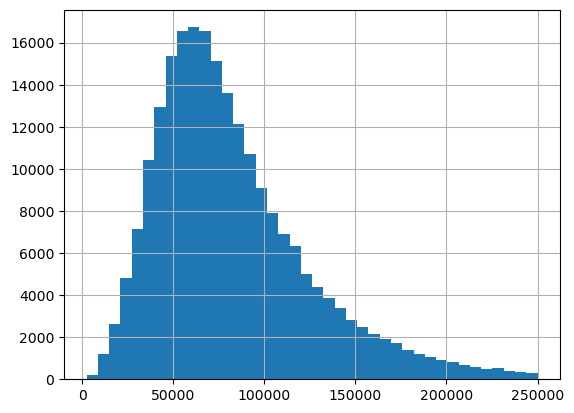

In [12]:
acs.B19013_001E.hist(bins=40)

In [34]:
breaks = [50000,70000,100000]
print("     low",sum( acs.B19013_001E  < breaks[0])/acs.shape[0])
print("lowermid",sum((acs.B19013_001E  >= breaks[0])&(acs.B19013_001E  < breaks[1]))/acs.shape[0])
print("uppermid",sum((acs.B19013_001E  >= breaks[1])&(acs.B19013_001E  < breaks[2]))/acs.shape[0])
print("    high",sum((acs.B19013_001E  >= breaks[2]))/acs.shape[0])


     low 0.22261887121181506
lowermid 0.239933722199022
uppermid 0.2693456189744902
    high 0.26810178761467274


In [37]:
acs["income_low"]      = np.where(acs.B19013_001E <  50000,1,0)
acs["income_lowermid"] = np.where((acs.B19013_001E >= 50000)&(acs.B19013_001E <  70000),1,0)
acs["income_uppermid"] = np.where((acs.B19013_001E >= 70000)&(acs.B19013_001E < 100000),1,0)
acs["income_high"]     = np.where(acs.B19013_001E >= 100000,1,0)

Var                    Mean    StdDev
-----------------  --------  --------
ACS homeownership  0.656647  0.272422
CEX homeownership  0.654677  0.475484


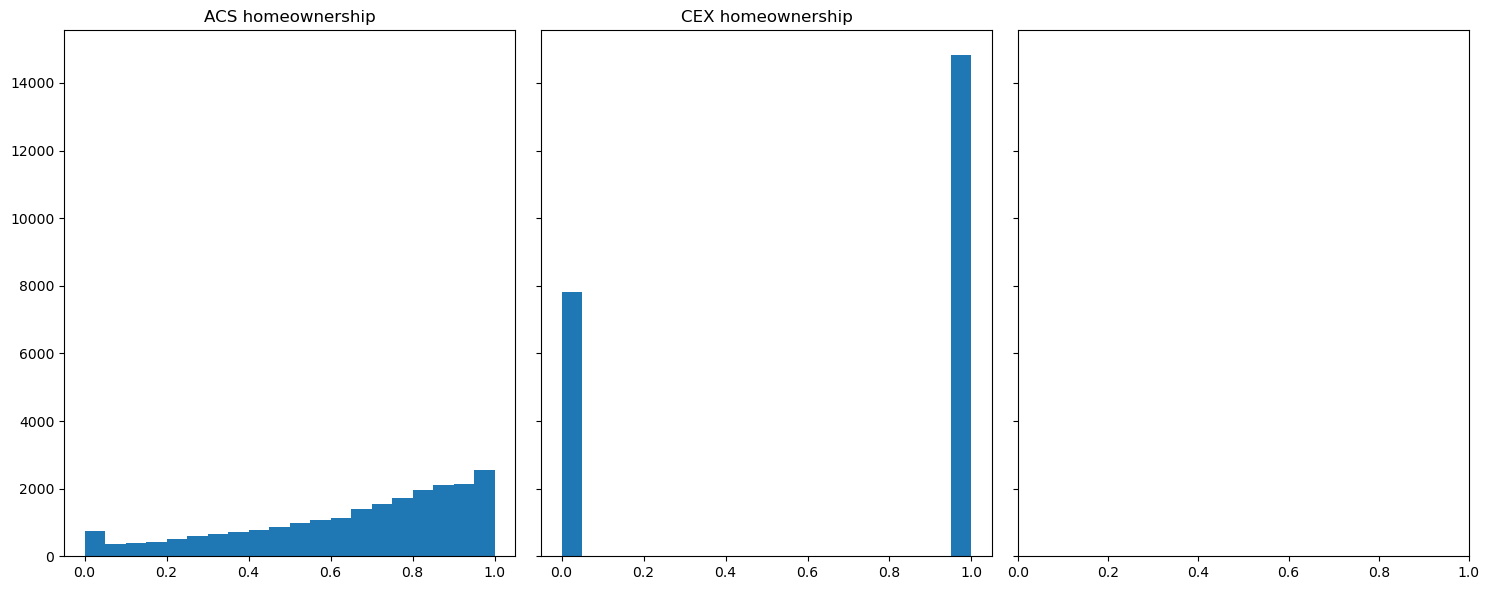

In [29]:
#
# Home Ownership (Tenure)
#
# ACS

fmli['homeownership'] = (fmli.CUTENURE.astype(int) < 4).astype(int) 
acs['homeownership'] = acs.B25003_002E/acs.B25003_001E  # proportion of occupied housing that is owned 

compare("ACS homeownership",acs.homeownership,"CEX homeownership", fmli.homeownership)

Var                   Mean    StdDev
----------------  --------  --------
ACS vehicles_0_1  0.409238  0.224408
CEX vehicles_0_1  0.488224  0.499872


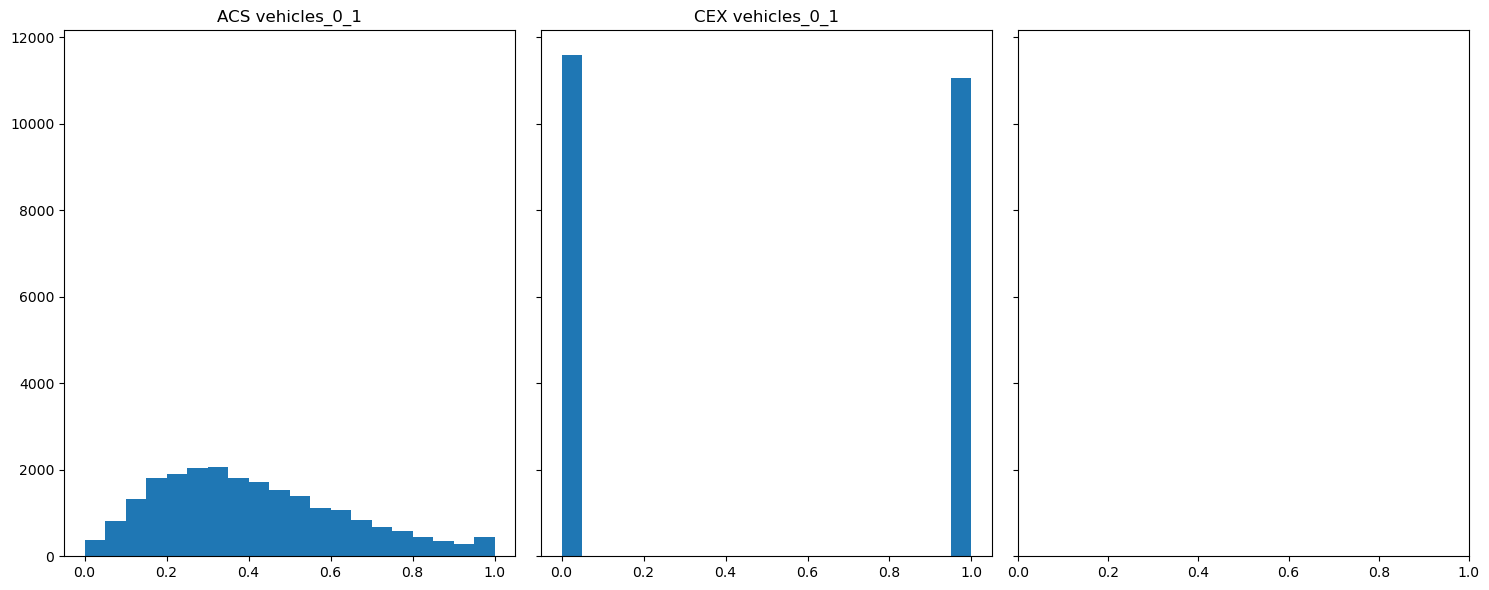

In [30]:
#
# Vehicle Ownership
#
cu = sum((fmli.FINLWT21 * fmli.MO_SCOPE / 3) / 4)

acs['vehicles_0_1'] = (acs.B25044_010E + acs.B25044_011E + acs.B25044_003E + acs.B25044_004E) / (acs.B25044_002E+acs.B25044_009E) 

fmli['vehicles_0_1'] = (fmli.VEHQ < 2).astype(int)

"""
B25044e9	Renter Occupied Vehicles Basis; 
B25044e10	No vehicle available; Renter occupied
B25044e11	1 vehicle available; Renter occupied
B25044e12	2 vehicles available; Renter occupied
B25044e13	3 vehicles available; Renter occupied
B25044e14	4 vehicles available; Renter occupied
B25044e15	5 or more vehicles available; Renter occupied
	
B25044e2	Owner Occupied Vehicles Basis; 
B25044e3	No vehicle available; Owner occupied
B25044e4	1 vehicle available; Owner occupied
B25044e5	2 vehicles available; Owner occupied
B25044e6	3 vehicles available; Owner occupied
B25044e7	4 vehicles available; Owner occupied
B25044e8	5 or more vehicles available; Owner occupied
"""

compare("ACS vehicles_0_1",acs.vehicles_0_1,"CEX vehicles_0_1", fmli.vehicles_0_1)

In [6]:



fmli.VEHQ.value_counts()

VEHQ
1     8309
2     6524
3     2887
0     2740
4     1162
5      515
6      195
7      129
8       75
9       36
10      21
11      13
12      11
14       6
16       2
23       2
13       2
15       2
Name: count, dtype: int64

Var              Mean    StdDev
-----------  --------  --------
ACS married  0.712799  0.210776
CEX married  0.466351  0.498878
Var               Mean    StdDev
------------  --------  --------
ACS children  0.401664  0.183654
CEX children  0.238125  0.425945


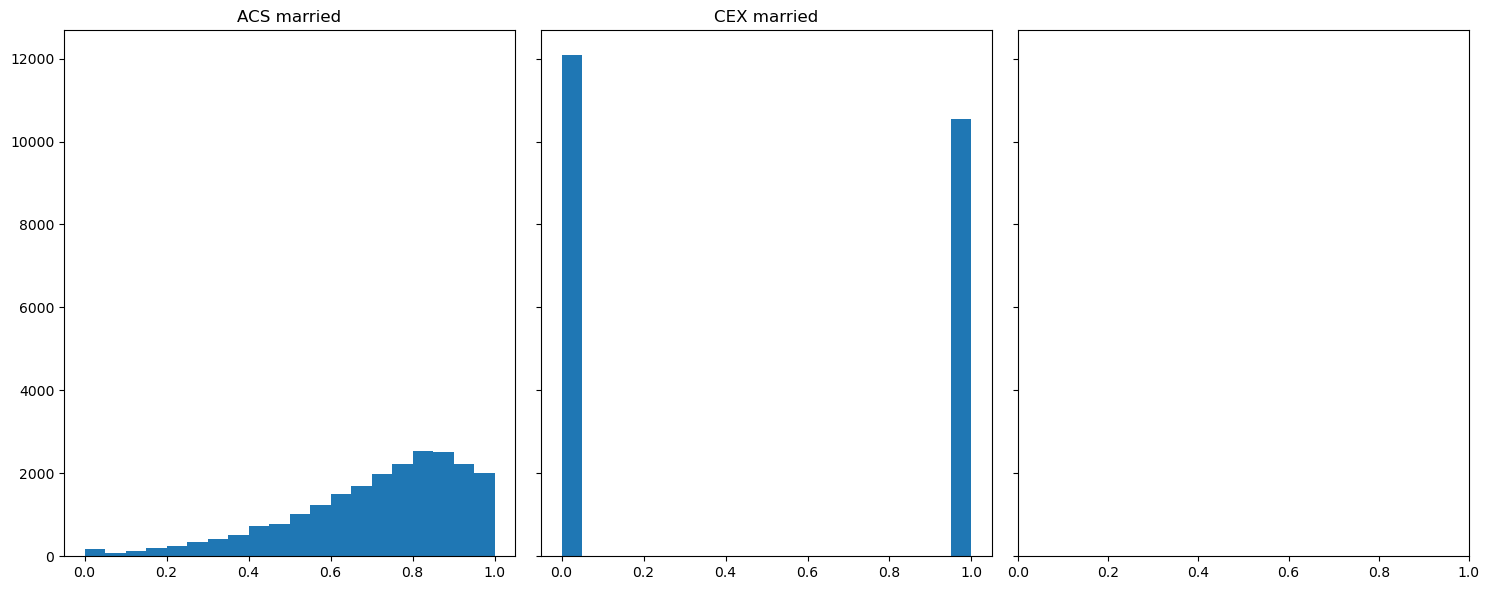

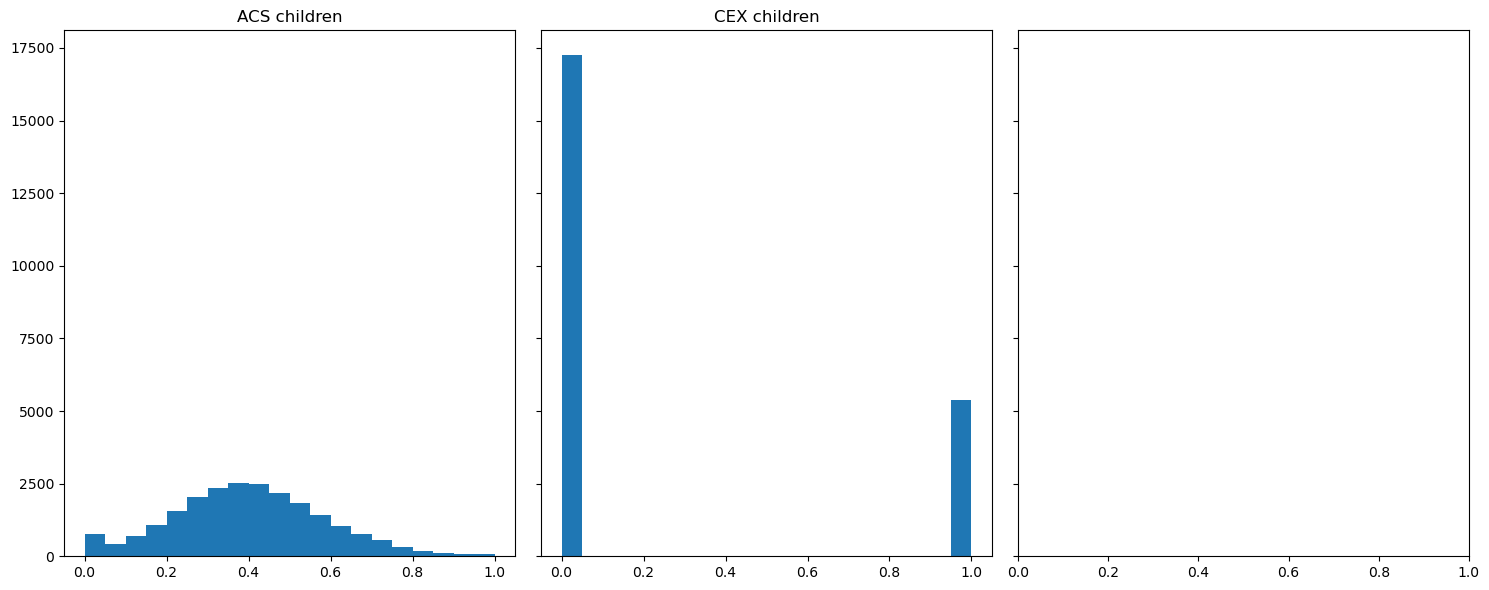

In [31]:
#
# Family Type
#
# Basically - Married x Presence of Children

fmli["married"] = (fmli.FAM_TYPE < 6).astype(int)
acs["married"] = acs["B11003_002E"]/acs["B11003_001E"]
compare("ACS married",acs.married,"CEX married", fmli.married)

fmli["children"] = (fmli.FAM_TYPE.isin([2,3,4,6,7])).astype(int)
# acs Married w Children, Single Dad w Children, Single Mom w Children
acs["children"] = (acs["B11003_003E"]+acs["B11003_010E"]+acs["B11003_016E"])/acs["B11003_001E"]
compare("ACS children",acs.children,"CEX children", fmli.children)


Var            Mean    StdDev
---------  --------  --------
ACS white  0.669252  0.276739
CEX white  0.800495  0.399637


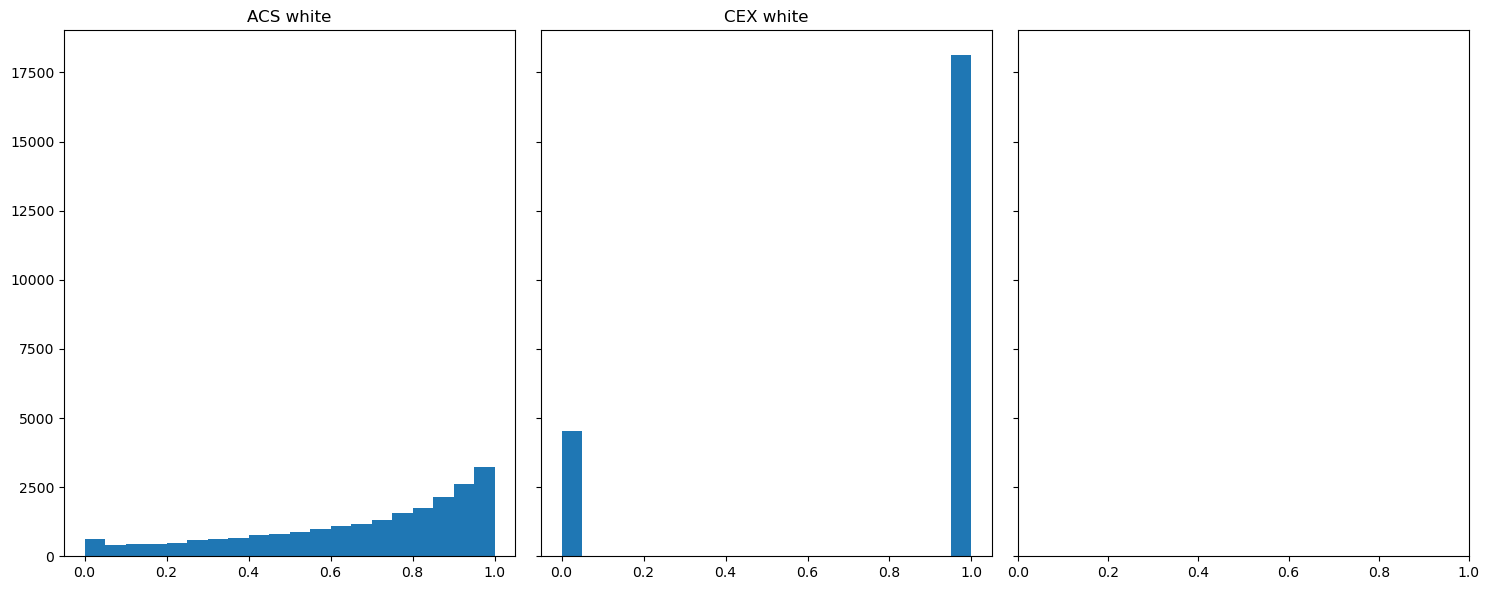

In [31]:
# 
# Race
#

# This may be where the model becomes an ensemble
# with each basis model dedicated to a race

fmli["white"] = np.where(fmli.REF_RACE.astype(int) == 1,1,0)
acs["white"] = acs.B02001_002E / acs.B02001_001E # Race basis

#REF_RACE
    #1	White
    #2	Black
    #3	Native American
    #4	Asian
    #5	Pacific Islander
    #6	Multi-race
#REF_HISP
    #1	Hispanic
    #2	Non-Hispanic

# fmli.groupby(['REF_RACE','HISP_REF']).size()
# 93% of Hispanics are White race

# FMLI create indicators
fmli['model_white'] = np.where((fmli.REF_RACE == 1) & (fmli.HISP_REF == 2),1,0)
fmli['model_black'] = np.where((fmli.REF_RACE == 2) & (fmli.HISP_REF == 2),1,0)
fmli['model_asian'] = np.where((fmli.REF_RACE == 4) & (fmli.HISP_REF == 2),1,0)
fmli['model_other'] = np.where((~fmli.REF_RACE.isin([1,2,4])) & (fmli.HISP_REF == 2),1,0)
fmli['model_hispanic'] = np.where(fmli.HISP_REF == 1,1,0)

# ACS:
#    B02001_001	Total:
#    B02001_002	White alone
#    B02001_003	Black or African American alone
#    B02001_004	American Indian and Alaska Native alone
#    B02001_005	Asian alone
#    B02001_006	Native Hawaiian and Other Pacific Islander alone
#    B02001_007	Some Other Race alone
#    B02001_008	Two or More Races:
#    B02001_009	Two races including Some Other Race
#    B02001_010	Two races excluding Some Other Race, and three or more races
# Hispanic:
#    B03001_001	Total:
#    B03001_002	Not Hispanic or Latino
#    B03001_003	Hispanic or Latino:

# ACS create proportions
acs['model_hispanic'] =  acs.B03003_003E.astype(int) / acs.B03003_001E.astype(int)
acs['model_white'] =  (acs.B02001_002E.astype(int) / acs.B02001_001E.astype(int)) - acs['model_hispanic']
acs['model_black'] =  acs.B02001_003E.astype(int) / acs.B02001_001E.astype(int)
acs['model_asian'] =  acs.B02001_005E.astype(int) / acs.B02001_001E.astype(int)
acs['model_other'] =  1 - acs.model_hispanic - acs.model_white - acs.model_black - acs.model_asian

compare("ACS white",acs.white,"CEX white", fmli.white)


Var                       Mean    StdDev
--------------------  --------  --------
ACS bedroomstwofewer  0.3736    0.260024
CEX bedroomstwofewer  0.373249  0.483678


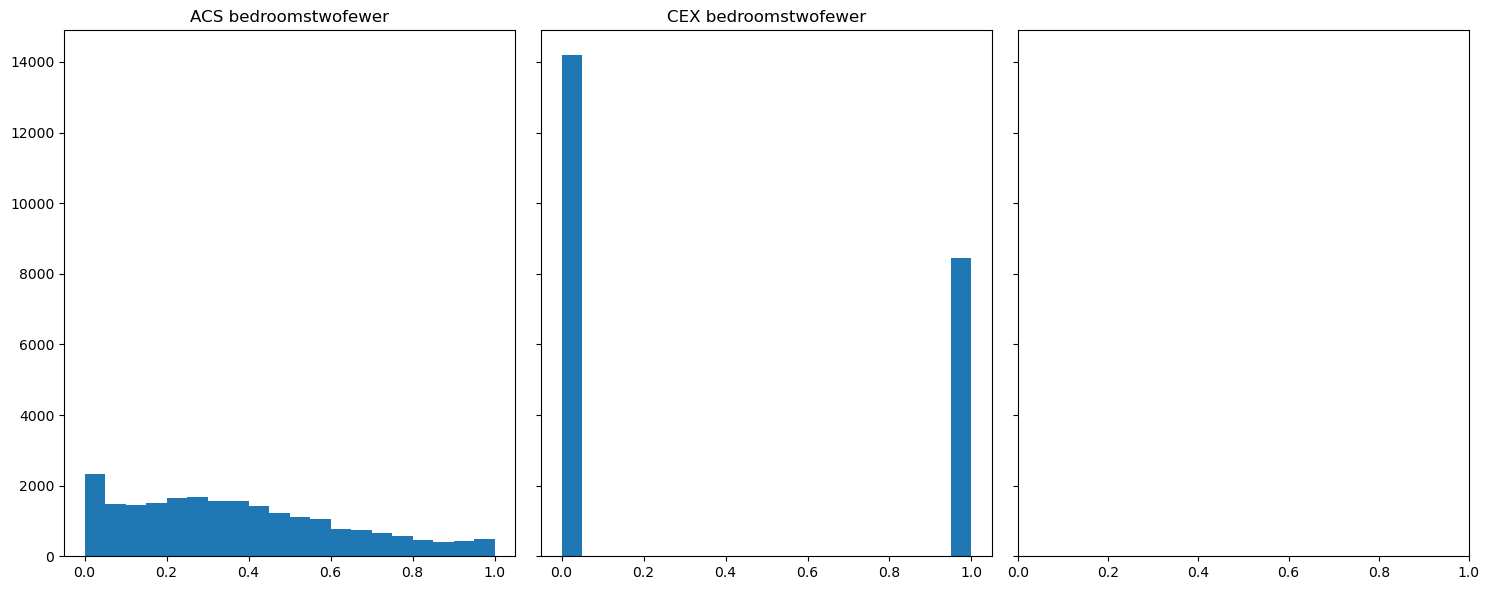

In [9]:
#ACS:	Bedrooms 	Universe:  Housing units
#   B25041_001	Total:
#   B25041_002	No bedroom
#   B25041_003	1 bedroom
#   B25041_004	2 bedrooms
#   B25041_005	3 bedrooms
#   B25041_006	4 bedrooms
#   B25041_007	5 or more bedrooms
#FMLI:
#   BEDROOMQ

acs['bedroomstwofewer'] =  (acs.B25041_002E.astype(int)+acs.B25041_003E.astype(int)+acs.B25041_004E.astype(int)) / acs.B25041_001E.astype(int)
fmli['bedroomstwofewer'] = np.where(fmli.BEDROOMQ<3,1,0)
compare("ACS bedroomstwofewer",acs.bedroomstwofewer,"CEX bedroomstwofewer", fmli.bedroomstwofewer)


In [12]:
fmli['vehicles_0'] = np.where(fmli.VEHQ == 0,1,0)
fmli['vehicles_1'] = np.where(fmli.VEHQ == 1,1,0)
fmli['vehicles_2'] = np.where(fmli.VEHQ == 2,1,0)
fmli['vehicles_3'] = np.where(fmli.VEHQ == 3,1,0)
fmli['vehicles_4'] = np.where(fmli.VEHQ == 4,1,0)
fmli['vehicles_5plus'] = np.where(fmli.VEHQ >= 5,1,0)


In [11]:
fmli.BEDROOMQ.value_counts()

BEDROOMQ
3.0     8827
2.0     5443
4.0     4115
1.0     2865
5.0      929
6.0      166
0.0      139
7.0       33
9.0        7
8.0        6
12.0       2
10.0       2
Name: count, dtype: int64

In [ ]:
fmli['bedrooms_0'] = np.where(fmli.BEDROOMQ == 0,1,0)
fmli['bedrooms_1'] = np.where(fmli.BEDROOMQ == 1,1,0)
fmli['bedrooms_2'] = np.where(fmli.BEDROOMQ == 2,1,0)
fmli['bedrooms_3'] = np.where(fmli.BEDROOMQ == 3,1,0)
fmli['bedrooms_4'] = np.where(fmli.BEDROOMQ == 4,1,0)
fmli['bedrooms_5plus'] = np.where(fmli.BEDROOMQ >= 5,1,0)

In [5]:
# House value
# B25077_001	Median value (dollars) owner occupied housing units

# Housing costs
# B25104_001    all NA
# B25105_001	all NA, Median Monthly Housing Costs, occupied units 

	



Block Group 1; Census Tract 201; Autauga County; Alabama: Summary level: 150, state:01> county:001> tract:020100> block group:1             None
Block Group 2; Census Tract 201; Autauga County; Alabama: Summary level: 150, state:01> county:001> tract:020100> block group:2             None
Block Group 1; Census Tract 202; Autauga County; Alabama: Summary level: 150, state:01> county:001> tract:020200> block group:1             None
Block Group 2; Census Tract 202; Autauga County; Alabama: Summary level: 150, state:01> county:001> tract:020200> block group:2             None
Block Group 1; Census Tract 203; Autauga County; Alabama: Summary level: 150, state:01> county:001> tract:020300> block group:1             None
                                                                                                                                            ... 
Block Group 1; Census Tract 7506.01; Yauco Municipio; Puerto Rico: Summary level: 150, state:72> county:153> tract:750601> block g

Var                 Mean    StdDev
----------  ------------  --------
ACS fuel_z  -3.59188e-15         1
CEX fuel_z  -1.23076e-16         1


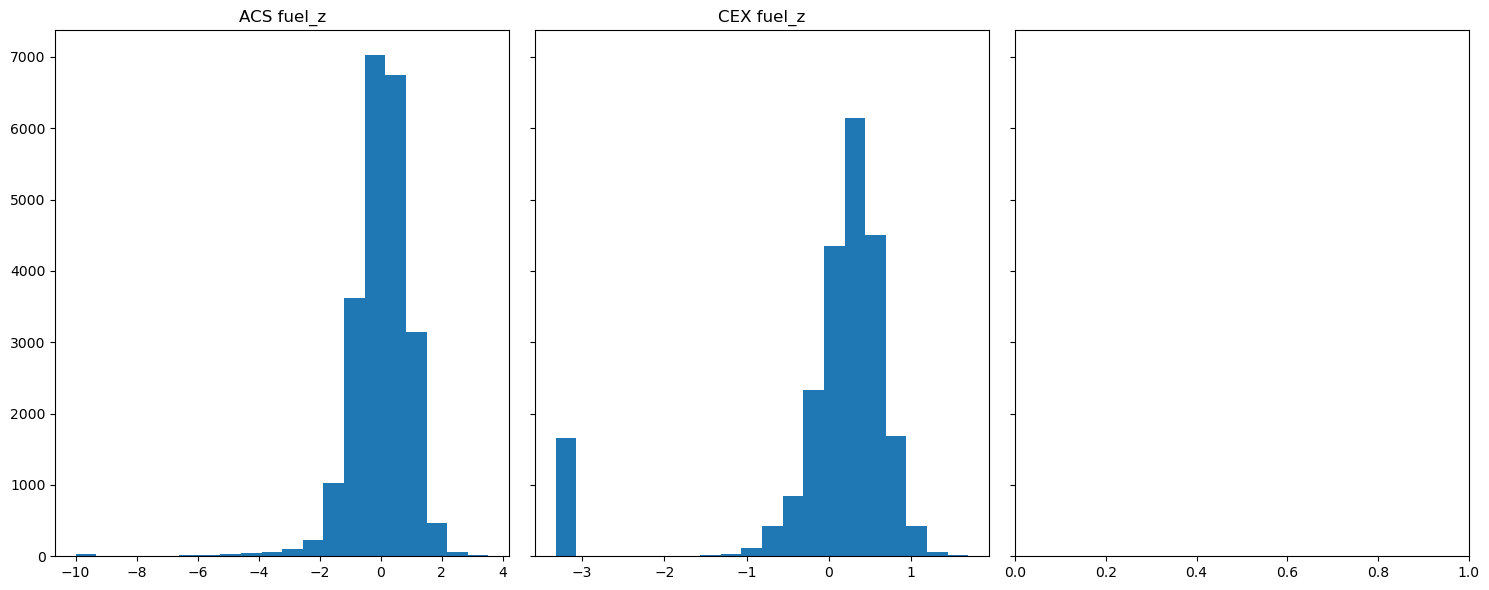

In [15]:
# Fuel spending

fmli['fuel_log'] = np.log(1+fmli['NTLGASCQ']+fmli['NTLGASPQ']+fmli['ELCTRCCQ'] + fmli['ELCTRCPQ']+fmli['ALLFULCQ']+fmli['ALLFULPQ'])
fmli['fuel_z'] = (fmli['fuel_log']-fmli['fuel_log'].mean()) / fmli['fuel_log'].std()

acs['fuel_log']  = np.log(1+acs['B25040_001E']-acs['B25040_010E'])
acs['fuel_z']  = (acs['fuel_log']-acs['fuel_log'].mean()) / acs['fuel_log'].std()

compare("ACS fuel_z",acs.fuel_z,"CEX fuel_z", fmli.fuel_z)


In [16]:
fmli['fuelbin'] = np.where(fmli['fuel_z'] < -1.5, 'A',
                 np.where(fmli['fuel_z'] < -.75, 'B',
                 np.where(fmli['fuel_z'] < -.25, 'C',
                 np.where(fmli['fuel_z'] < .25, 'D',
                 np.where(fmli['fuel_z'] < .75, 'E', 
                 np.where(fmli['fuel_z'] < 1.5, 'F', 'G'))))))

fmli.incbin.value_counts(normalize=True)

incbin
E    0.224117
D    0.208696
F    0.179267
C    0.163758
B    0.130485
A    0.057222
G    0.036454
Name: proportion, dtype: float64

In [11]:
# Household Sizes

# B11016_001	Total:
# B11016_002	Family households:
# B11016_003	2-person household
# B11016_004	3-person household
# B11016_005	4-person household
# B11016_006	5-person household
# B11016_007	6-person household
# B11016_008	7-or-more person household
# B11016_009	Nonfamily households:
# B11016_010	1-person household
# B11016_011	2-person household
# B11016_012	3-person household
# B11016_013	4-person household
# B11016_014	5-person household
# B11016_015	6-person household
# B11016_016	7-or-more person household

acs['familysize_1'] = acs.B11016_010E
acs['familysize_2'] = acs.B11016_003E + acs.B11016_011E
acs['familysize_3'] = acs.B11016_004E + acs.B11016_012E
acs['familysize_4'] = acs.B11016_005E + acs.B11016_013E
acs['familysize_5'] = acs.B11016_006E + acs.B11016_014E
acs['familysize_6'] = acs.B11016_007E + acs.B11016_015E
acs['familysize_7more'] = acs.B11016_008E + acs.B11016_016E

fmli['familysize_1'] = np.where(fmli.FAM_SIZE == 1, 1, 0)
fmli['familysize_2'] = np.where(fmli.FAM_SIZE == 2, 1, 0)
fmli['familysize_3'] = np.where(fmli.FAM_SIZE == 3, 1, 0)
fmli['familysize_4'] = np.where(fmli.FAM_SIZE == 4, 1, 0)
fmli['familysize_5'] = np.where(fmli.FAM_SIZE == 5, 1, 0)
fmli['familysize_6'] = np.where(fmli.FAM_SIZE == 6, 1, 0)
fmli['familysize_7more'] = np.where(fmli.FAM_SIZE >= 7, 1, 0)


In [ ]:
#######################################################################################################
#
# Draft models
#
##################################################################################

In [22]:
X = fmli[independents]
y = fmli['TOTEXP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 
#import statsmodels.api as sm
#model = sm.OLS(y,X).fit()
#print(model.summary())
# R2 is .778

# Polynomial regression 
# R2 is 0.5243994759790682
#

# XGBoostRegressor 
# R2 is 0.49064753153485297
"""
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

X = fmli[independents]
y = fmli['TOTEXP']

print("Fitting")
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(X_train, y_train)
print("Predicting")
y_pred = model.predict(X_test)
print("rmse:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2", r2_score(y_test, y_pred))
"""

# Decision Tree Regressor
# R2 is .4731
"""
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2",r2)
"""

r2 0.47310760425856724


Var            Mean    StdDev
----------  -------  --------
ACS Income  53798.1   12596.8
CEX Income  69423.3   60039.3


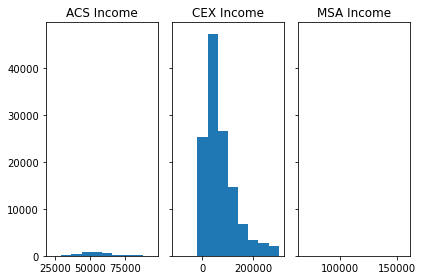

In [3]:
######################################################################################################
#
# FIRST ATTEMPTS
#
#######################################################################################################

##########
#Var            Mean    StdDev
#----------  -------  --------
#ACS Income  53489.2   10479     NORMALLY DISTRIBUTED
#CEX Income  86563     85839.5   POISSON DISTRIBUTED
acsinc = pd.read_csv(ACSDIR + "ACSDT5Y2020.B19013_2022-10-10T170857-County\\ACSDT5Y2020.B19013-Data.csv").drop([0],axis=0)
acsinc['B19013_001E'] = acsinc['B19013_001E'].astype(str)
acsinc['B19013_001E'] = acsinc['B19013_001E'].replace('-',np.nan)
acsinc['B19013_001E'] = acsinc['B19013_001E'].astype(float)

a = acsinc['B19013_001E'].dropna().sort_values().reset_index(drop=True)
aoutliers = 2*int(len(a)/100)

b = fmli[fmli.FINCBTXM < 300000].FINCBTXM.astype(float)
boutliers = 2*int(len(b)/100)

c = msacompare["Income before taxes"]

compare('ACS Income',a[aoutliers:len(a)-aoutliers],
        'CEX Income',b[boutliers:len(b)-boutliers],
        'MSA Income',c)


Var          Mean    StdDev
--------  -------  --------
ACS rent  1348.38   634.643
CEX rent  1340.38  2454.89


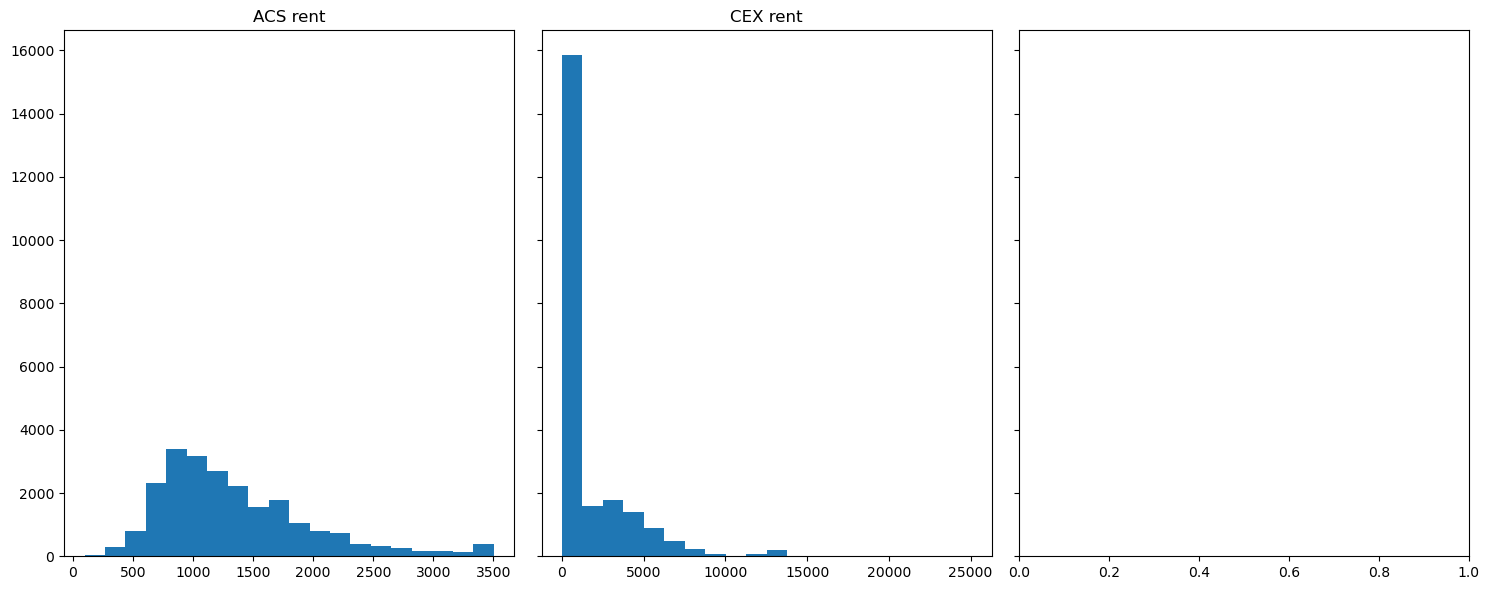

In [18]:
# Rent
# ACS:
#    B25064_001E  Median Gross Rent
# FMLI
#    RENDWECQ,RENDWEPQ   Rented Dwelling this/last quarter


# HERES A PROBLEM - THIS IS ONLY MEANINGFUL FOR THE RENTERS IN A GEOG
# Median Gross Rent has many NAs with the value -666666666  (27% of block groups)
# I can't find an equivalent owner/mortgage cost

fmli['rent_log'] = np.log(1+fmli['RENDWECQ'] + fmli['RENDWEPQ'])
acs['rent_log'] = np.log(1+acs['B25064_001E'])

compare("ACS rent",acs.rent[acs['B25064_001E']>0],"CEX rent", fmli.rent)



In [ ]:
# Compare proportions to BLS 
# https://www.bls.gov/news.release/cesan.nr0.htm
# for c in dependents:
#     fmli["WTD_"+c] = fmli["WTD_"+c+"CQ"] +fmli["WTD_"+c+"PQ"] 
# fmli[["WTD_"+c for c in dependents]].sum() / fmli.WTD_TOTEXP.sum()

Var          Mean    StdDev
--------  -------  --------
ACS Rent  2329.45   635.263
CEX Rent  1476.5   1034.87


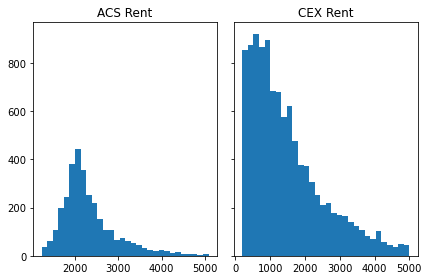

In [16]:
# 
# Rent
#

# ACS is monthly Median Gross Rent (Dollars) which includes home utilities and fuel costs
#B25070

# CEX is quarterly 
#        RNTXRPCQ "Rent excluding rent as pay this quarter" 
#        RENTEQVX If someone were to rent your home today, how much do you think it would rent for monthly, unfurnished and without utilities?
#
#        SHELTCQ "Shelter this quarter"

# Again CEX looks 

acsrent = pd.read_csv(ACSDIR + "ACSDT5Y2020.B25064_2022-10-19T164615\\ACSDT5Y2020.B25064-Data.csv",dtype=object).drop([0],axis=0)
acsrent['B25064_001E'] = acsrent['B25064_001E'].astype(str)
acsrent['B25064_001E'] = acsrent['B25064_001E'].replace('-',np.nan)
acsrent['B25064_001E'] = acsrent['B25064_001E'].astype(float)

a = 3 * acsrent['B25064_001E'].dropna().sort_values().reset_index(drop=True)
aoutliers = 1*int(len(a)/100)
#b = fmli.RENDWECQ.astype(float) + fmli.UTILCQ.astype(float)
b = fmli.SHELTCQ.astype(float)
b = b[(b>200) & (b<5000)]
boutliers = 5*int(len(b)/100)

compare('ACS Rent',a[aoutliers:len(a)-aoutliers],
        'CEX Rent',b[boutliers:len(b)-boutliers])


Var                Mean    StdDev
-------------  --------  --------
ACS ownership  0.656647  0.272422
CEX ownership  0.435951  0.495892


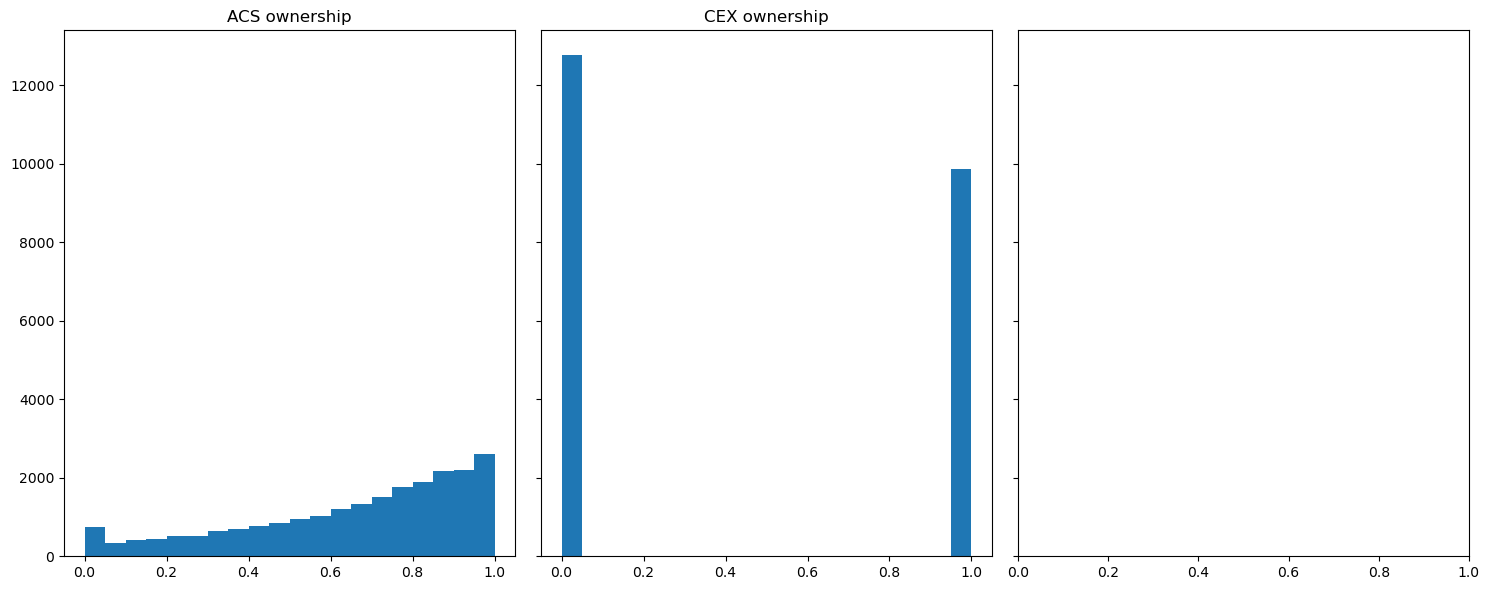

In [84]:
#
# Tenure
#
acs['ownership'] = acs["B25003_002E"].astype(float)/acs["B25003_001E"].astype(float)
fmli['ownership'] = (fmli.OWNDWECQ > 0).astype(int)
compare("ACS ownership",acs.ownership,"CEX ownership", fmli.ownership)

In [34]:
fmli[fmli.fuel == 0].shape

(1654, 904)

In [35]:
fmli.shape

(22631, 904)

In [28]:
sum(fmli.fuel <0)

0

Var                Mean     StdDev
-------------  --------  ---------
ACS Ownership  0.633583  0.0672982
CEX Ownership  0.621537  0.0573511
Var                 Mean     StdDev
--------------  --------  ---------
ACS Rentership  0.350275  0.0699006
CEX Rentership  0.378463  0.0573511
Var                Mean      StdDev
-------------  --------  ----------
ACS Totalship  0.983858  0.00816949
CEX Totalship  1         0


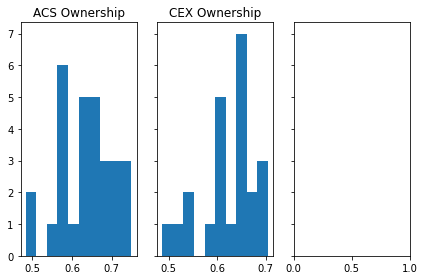

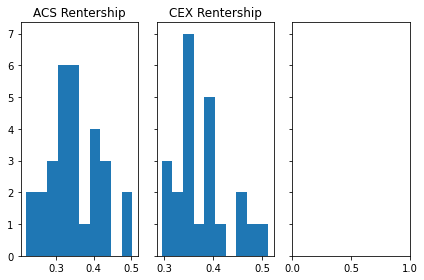

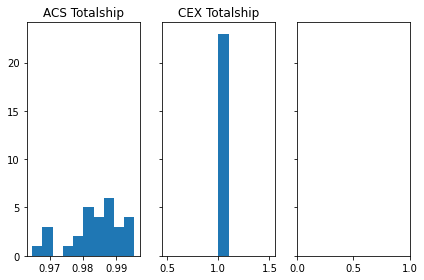

In [18]:
#
# Tenure
#
# ACS "B25003_001E","B25003_002E","B25003_003E"
# CEX CUTENURE

# Make them both proportions
#acstenure = pd.read_csv(ACSDIR + "ACSDT5Y2020.B25003_2022-10-26T153046-MSA\\ACSDT5Y2020.B25003-Data.csv").drop([0],axis=0)
#acstenure = acstenure[acstenure.GEO_ID.str[-5:].isin(msacodes["OMB MSA 1"])]
#acstenure["ownership"]  = acstenure["B25003_002E"].astype(float)/acstenure["B25003_001E"].astype(float)
#acstenure["rentership"] = acstenure["B25003_003E"].astype(float)/acstenure["B25003_001E"].astype(float)
#acstenure['state'] = acstenure.GEO_ID.str[9:11]


# 1 	Owned w/mortgage:
# 2 	Owned w/o mortgage:
# 3 	Owned mortgage NR:
# 4 	Rented
# 5 	Occupied w/o payment of cash rent:
# 6 	Student housing
#
# Im guessing this could be turned into proportions  -  % Owned  vs % Renting vs % Other             
              
fmli["PSU"].fillna("NA",inplace = True)
fmli["POPSIZE"].fillna("NA",inplace = True)
fmli["BLS_URBN"].fillna("NA",inplace = True)
fmli["geog"] = fmli["PSU"] + "-" + fmli["POPSIZE"] + "-" + fmli["BLS_URBN"]

df = fmli[['geog','CUTENURE']].groupby(['geog','CUTENURE']).size().to_frame('size').reset_index()
newdf = pd.pivot_table(df,index=["geog"],columns='CUTENURE',aggfunc='sum').reset_index()
newdf.columns = ['geog','1','2','4','5','6']
newdf["sum"] = newdf.sum(axis=1)
newdf["ownership"] = (newdf["1"]+newdf["2"] )/ newdf["sum"]
newdf["rentership"] = newdf["4"]/ newdf["sum"]

a = newdf["ownership"]
#b = acstenure[["state","ownership","rentership"]].groupby('state').mean()["ownership"]
b = acstenure["ownership"]
aoutliers = 10*int(len(a)/100)
boutliers = 10*int(len(b)/100)

compare('ACS Ownership',a[aoutliers:len(a)-aoutliers],
        'CEX Ownership',b[boutliers:len(b)-boutliers])

a = newdf["rentership"]
#b = acstenure[["state","ownership","rentership"]].groupby('state').mean()["rentership"]
b = acstenure["rentership"]
aoutliers = 10*int(len(a)/100)
boutliers = 10*int(len(b)/100)

compare('ACS Rentership',a[aoutliers:len(a)-aoutliers],
        'CEX Rentership',b[boutliers:len(b)-boutliers])

a = newdf["rentership"]+newdf["ownership"]
b = acstenure["rentership"]+acstenure["ownership"]

compare('ACS Totalship',a[aoutliers:len(a)-aoutliers],
        'CEX Totalship',b[boutliers:len(b)-boutliers])



Var              Mean    StdDev
-----------  --------  --------
ACS white %  0.622222  0.129452
CEX white %  0.756088  0.129692
Var              Mean     StdDev
-----------  --------  ---------
ACS black %  0.137286  0.0878924
CEX black %  0.122702  0.0816619
Var                 Mean     StdDev
------------  ----------  ---------
ACS native %  0.00789962  0.0144195
CEX native %  0.00608222  0.0114575
Var               Mean     StdDev
-----------  ---------  ---------
ACS asian %  0.0975699  0.0893671
CEX asian %  0.086646   0.0975392
Var                  Mean     StdDev
-------------  ----------  ---------
ACS pacific %  0.00686581  0.0208337
CEX pacific %  0.00691422  0.0149378
Var               Mean     StdDev
-----------  ---------  ---------
ACS other %  0.128157   0.0648396
CEX other %  0.0187239  0.0308957


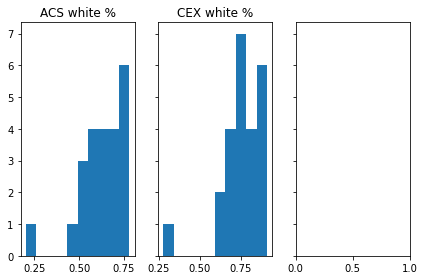

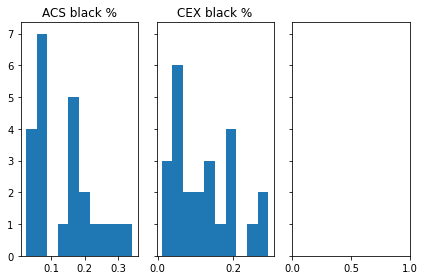

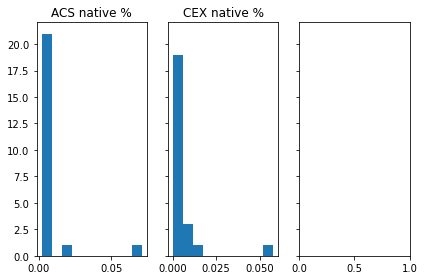

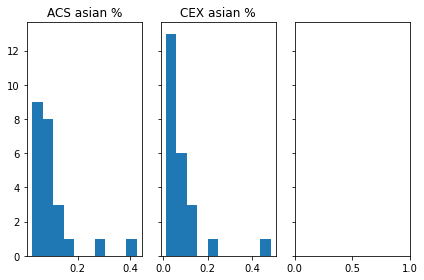

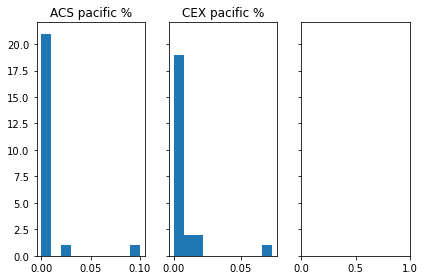

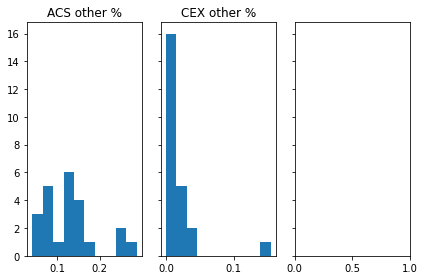

In [19]:
#
# Proportion non-white race
#

acsrace = pd.read_csv(ACSDIR + "ACSDT5Y2020.B02001_2022-10-26T175703-MSA\\ACSDT5Y2020.B02001-Data.csv").drop([0],axis=0)

for var in ['1','2','3','4','5','6']:
    acsrace["B02001_00"+var+"E"] = acsrace["B02001_00"+var+"E"].astype(float)

acsrace["race_white"]  = acsrace["B02001_002E"]/acsrace["B02001_001E"]
acsrace["race_black"]  = acsrace["B02001_003E"]/acsrace["B02001_001E"]
acsrace["race_native"] = acsrace["B02001_004E"]/acsrace["B02001_001E"]
acsrace["race_asian"]  = acsrace["B02001_005E"]/acsrace["B02001_001E"]
acsrace["race_pacific"]  = acsrace["B02001_006E"]/acsrace["B02001_001E"]
acsrace["race_other"]  = 1 - (acsrace["race_white"] +\
                              acsrace["race_black"] +
                              acsrace["race_native"] +
                              acsrace["race_asian"] +
                              acsrace["race_pacific"] )

acsrace = acsrace[acsrace.GEO_ID.str[-5:].isin(msacodes["OMB MSA 1"])]

# fmli.REF_RACE
#1	White
#2	Black
#3	Native American
#4	Asian
#5	Pacific Islander
#6	Multi-race

# In general, we're going to have to summarize the fmli, by its geog
# SO: flags like sex, race, etc become counts
pumdrace = fmli[['PSU','REF_RACE']].groupby(['PSU','REF_RACE']).size().to_frame('size').reset_index()
newdf = pd.pivot_table(pumdrace,index=["PSU"],columns='REF_RACE',aggfunc='sum').reset_index()
newdf.columns =  ['PSU','1','2','3','4','5','6']
newdf["sum"] = newdf.sum(axis=1)

newdf["race_white"]   = newdf["1"]/ newdf["sum"]
newdf["race_black"]   = newdf["2"]/ newdf["sum"]
newdf["race_native"]  = newdf["3"]/ newdf["sum"]
newdf["race_asian"]   = newdf["4"]/ newdf["sum"]
newdf["race_pacific"] = newdf["5"]/ newdf["sum"]
newdf["race_other"]   = 1 - (newdf["race_white"] + \
                            newdf["race_black"] +
                            newdf["race_native"] +
                            newdf["race_asian"] +
                            newdf["race_pacific"] )
newdf.fillna(0,inplace=True)

for race in ['white','black','native','asian','pacific','other']:
    a = acsrace["race_" + race]
    b = newdf["race_" + race]

    aoutliers = 5*int(len(a)/100)
    boutliers = 5*int(len(b)/100)

    compare('ACS '+race+' %',a[aoutliers:len(a)-aoutliers],
            'CEX '+race+' %',b[boutliers:len(b)-boutliers])


In [ ]:

#
# Get MSA Population Density with B01001e1 and ALAND
#

print("Get MSA Population Density")

# Land Area from TIGER\Line
import geopandas as gpd
acstiger = gpd.read_file("D:\\Open Environments\\data\\census\\tiger\\tl_2021_us_cbsa")
acstiger["GEOID"] = acstiger["GEOID"].astype(str)

# Population from ACS TIGER\Line
ACSDIR = "D:\\Open Environments\\data\\census\\acs\\acs5\\2020\\"
B01 = "ACSDT5Y2020.B01001_2022-10-05T135613\\ACSDT5Y2020.B01001-Data.csv"
acspop = pd.read_csv(ACSDIR + B01)
acspop.drop([0],inplace=True)   # first row is just long desc of each column name
msapop["MSA"] = msapop["GEO_ID"].str[-5:]

# Three way join - pop,land,codes
acspopland = pd.merge(acstiger,acspop,left_on="GEOID",right_on="MSA",how="inner")[["MSA","B01001_001E","ALAND"]]
acspopland["B01001_001E"] = acspopland["B01001_001E"].astype(int)
acspopland["msadensity"] = acspopland["B01001_001E"] / (acspopland["ALAND"] / 1000000)


In [ ]:
import pandas as pd
import numpy as np
#import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sb

ACSDIR = "D:\\Open Environments\\data\\census\\acs\\acs5\\2020\\"
MSADIR = "D:\\Open Environments\\data\\bls\\cex\\msa\\"
REGIONS = ['northeast', 'south', 'midwest', 'west']
YEARS = ['2020']

#
# Get the PUMD
#
print("Get the PUMD")
fmli = pd.read_pickle('fmli.pkl')
#fmld = pd.read_pickle('fmld.pkl')
#expd = pd.read_pickle('expd.pkl')
#mtbi = pd.read_pickle('mtbi.pkl')

#fmli = fmli[fmli.year == "2020"]
#fmld = fmld[fmld.year == "2020"]
#mtbi = mtbi[mtbi.year == "2020"]
#expd = expd[expd.year == "2020"]

fmli["TOTEXPCQ"] = fmli["TOTEXPCQ"].astype(float)
fmli = fmli[fmli.TOTEXPCQ > 1]  # Roughly a third of interviews have no spend recorded

fmli["FINCBTXM"] = fmli["FINCBTXM"].astype(float)
fmli = fmli[fmli.FINCBTXM > 1]  # Roughly ten households a year record negative income (dunno how)

# Ignore 32.5% of obs that have zero spending but have mean income of 87K
# Removing the zero values, allows log transforms
#fmli = fmli[fmli["TOTEXPCQ"] > 0]
#fmli = fmli[fmli["FINCBTXM"] > 0]

# Consider summarizing the fmld UCCs to calc the TOTEXPCQ and its components 

"""
#
# Get the MSA summaries
#
print("Get the CEX MSA summaries")

from oe_bls import oe_bls_cex_msa

for year in YEARS:
    msa,msacoded,cexvariables,msacodes = oe_bls_cex_msa.oe_bls_cex_msa_open(year, regions=REGIONS, msadir=MSADIR)

msacodes["OMB MSA 1"] = msacodes["OMB MSA 1"].astype(str)

msacompare = msacoded.T
msacompare.columns = msacompare.iloc[0]
msacompare.drop(['Item','HGLevel', 'ReportTitle', 'Var','Notes'],axis=0,inplace=True)
msacompare = msacompare.reset_index().rename(columns={'index':'CPI Area'})
msacompare = pd.merge(msacompare,msacodes,how='inner',on='CPI Area')
"""


# according to BLS, https://www.bls.gov/cex/cecomparison/acs_profile.htm
# the CEX and ACS share:
#    persons per household - exactly   (1.0 stdev 0.01)
#        ACS is allegedly larger, an address can have multiple CUs (rarely)
#    income                - CE is .91 x ACS, stddev 0.02
#        FINCBTXM          Total Annual Income, as collected or imputed
#        B19013e1
#    rent                  - CE is .91 x ACS, stddev 0.04
#        B25064e1 Median gross rent (dollars)
#        RENDWECQ
#    
#    mortgage payment      - CE is 1.1 x ACS, stddev 0.02
#        B25081e1 Mortgage Status	Mortgage Costs	Owner-occupied housing units	Estimate	MORTGAGE STATUS	Owner-occupied housing units	Total
#        OWNDWECQ 
# DP04 Selected Housing Unit Characteristics
#   Selected Monthly Ownership Costs (SMOC)
#     Housing units with a mortgage
#     Housing units without a mortgage

#    utilities             - CE is .89 x ACS, stddev 0.01

# Tenure is a subject we can relate manually
#        CUTENURE




In [16]:
cexdata = fmli

cexdata = cexdata[cexdata.TOTEXPCQ > 0]
cexdata = cexdata[cexdata.FINCBTXM > 0]
cexdata = cexdata[~cexdata.PSU.isna()]

print('Training')
modelvars = []
cexvars = []

#############################################################
# Create variables on CEX that map to ACS

# SPENDING
modelvars.append('spending')
cexvars.append('TOTEXPCQ')
cexdata['spending'] = cexdata['TOTEXPCQ']

# INCOME
modelvars.append('income')
cexvars.append('FINCBTXM')
cexdata['income'] = cexdata['FINCBTXM']

# RACE
for var in ['race_white','race_black','race_native','race_asian','race_pacific','race_other']:
    modelvars.append(var)
cexvars.append('REF_RACE')

# Using np.where rather than get_dummies, in case each value is missing in the observed data
cexdata['race_white']    = np.where(cexdata.REF_RACE == '1',1,0) 
cexdata['race_black']    = np.where(cexdata.REF_RACE == '2',1,0)
cexdata['race_native']   = np.where(cexdata.REF_RACE == '3',1,0)
cexdata['race_asian']    = np.where(cexdata.REF_RACE == '4',1,0)
cexdata['race_pacific']  = np.where(cexdata.REF_RACE == '5',1,0)
cexdata['race_other']    = 1 - (cexdata['race_white'] + \
                                cexdata['race_black'] +
                                cexdata['race_native'] +
                                cexdata['race_asian'] +
                                cexdata['race_pacific'] )
# ETHNICITY
for var in ['ethnic_nothispanic','ethnic_hispanic']:
    modelvars.append(var)
cexvars.append('HISP_REF')
cexdata['ethnic_nothispanic'] = np.where(cexdata['HISP_REF'] != '1',1,0)
cexdata['ethnic_hispanic']    = np.where(cexdata['HISP_REF'] == '1',1,0)

# TENURE
for var in ['tenure_owner','tenure_renter']:
    modelvars.append(var)
cexvars.append('CUTENURE')
cexdata['tenure_owner'] = np.where((cexdata.CUTENURE == '1')|(cexdata.CUTENURE == '2')|(cexdata.CUTENURE == '3'),1,0)
cexdata['tenure_renter'] = np.where(cexdata.CUTENURE == '4',1,0)

# FAMILY SIZE
modelvars.append('family_size')
cexvars.append('FAM_SIZE')
cexdata['family_size'] = cexdata['FAM_SIZE']

# STATE
states = pd.read_csv('https://raw.githubusercontent.com/OpenEnvironments/core/main/states.csv', dtype=str)
states['StateFIPS'] = states.StateFIPS.str.zfill(2)

#for s in states['StateFIPS'][~states.CensusName.isna()]:
for s in cexdata.STATE.unique():
    modelvars.append('state_'+s)
cexvars.append('FAM_SIZE')

# CEX does not include all states, generate 
cexmissingstates = \
    {'40':'20',   # Oklahoma: Kansas
     '05':'40',  # Arkansas: Oklahoma
     '16':'46',  # Idaho: South Dakota
     '23':'33',  # Maine: New Hampshire
     '30':'46',  # Montana: South Dakota
     '35':'04',  # New Mexico: Arizona:
     '38':'46',  # North Dakota: South Dakota
     '44':'09',  # Rhode Island: Connecticut
     '50':'33',  # Vermont: New Hampshire
     '56':'46',  # Wyoming:South Dakota
     '72':'25'   # Puerto Rick: Massachussets
    }

cexstate = pd.get_dummies(cexdata.STATE)
#for s in cexmissingstates.keys():
#    cexstate[s] = cexstate[cexmissingstates[s]]
cexstate.columns = ['state_'+c for c in cexstate.columns]
cexdata = pd.concat([cexdata,cexstate], axis=1)

# MSA
for m in [x for x in cexdata.PSU.unique() if str(x) != 'nan']:
    modelvars.append('msa_'+m)
cexvars.append('PSU')

cexmsa = pd.get_dummies(cexdata.PSU)
cexmsa.columns = ['msa_'+c for c in cexmsa.columns]

cexdata = pd.concat([cexdata,cexmsa], axis=1)

# DENSITY



#####################################################################
# Train, summarize and save the model

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

X = cexdata[\
    [c for c in modelvars if c not in 
    ['spending','race_white','ethnic_hispanic','tenure_renter','state_01','msa_']]]
X = X.astype(float)
X['intercept'] = 1
y = cexdata['spending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)

model = sm.OLS(y,X)
results = model.fit()

print("Model variables are:",modelvars)
print(results.summary())
results.save('blockgroupspending_regression.pkl')

results_fr = model.fit_regularized(L1_wt=0, alpha=0.04, start_params=results.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_fr.params, 
                                              model.normalized_cov_params)

print(final.summary())


Training
Model variables are: ['spending', 'income', 'race_white', 'race_black', 'race_native', 'race_asian', 'race_pacific', 'race_other', 'ethnic_nothispanic', 'ethnic_hispanic', 'tenure_owner', 'tenure_renter', 'family_size', 'state_06', 'state_34', 'state_48', 'state_17', 'state_12', 'state_13', 'state_36', 'state_08', 'state_42', 'state_33', 'state_26', 'state_53', 'state_15', 'state_51', 'state_24', 'state_02', 'state_04', 'state_11', 'state_27', 'state_25', 'state_29', 'state_10', 'state_18', 'msa_S49A', 'msa_S12A', 'msa_S37B', 'msa_S23A', 'msa_S35B', 'msa_S49B', 'msa_S35C', 'msa_S48B', 'msa_S12B', 'msa_S11A', 'msa_S23B', 'msa_S49D', 'msa_S37A', 'msa_S24B', 'msa_S49F', 'msa_S35A', 'msa_S35E', 'msa_S49G', 'msa_S48A', 'msa_S24A', 'msa_S49C', 'msa_S49E', 'msa_S35D']
                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:      

In [1]:
[c for c in ['TOTEXP','FOOD','ALCBEV','HOUS','APPAR','TRANS','HEALTH', 'ENTERT',
           'PERSCA', 'READ','EDUCA','TOBACC','MISC', 'CASHCO','RETPEN']]

['TOTEXP',
 'FOOD',
 'ALCBEV',
 'HOUS',
 'APPAR',
 'TRANS',
 'HEALTH',
 'ENTERT',
 'PERSCA',
 'READ',
 'EDUCA',
 'TOBACC',
 'MISC',
 'CASHCO',
 'RETPEN']